<a href="https://colab.research.google.com/github/kaybrian/Maternal-Health-Risk-Data-ML-model/blob/main/Maternal_Health_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Import the needed Modules for the project

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline


In [13]:
# Import the data needed for the work
data = pd.read_csv('/content/Maternal Health Risk Data Set.csv')

# View the first few rows of the dataset
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
#  Check the summary statistics of the dataset
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [4]:
# Check for missing values in the dataset
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [5]:
# View the data types of each column
data.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [9]:
# look at teh Risk Level and one Hot encode it
data['RiskLevel'].value_counts()


RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

In [16]:
# hot encode the RiskLevel usign SKlearn one hot encoder
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(data[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([data, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Print the first few rows of the encoded dataframe
df_encoded.sample(20)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel_high risk,RiskLevel_low risk,RiskLevel_mid risk
1000,12,90,60,11.0,102.0,60,1.0,0.0,0.0
415,60,140,90,12.0,98.0,77,1.0,0.0,0.0
801,23,130,70,6.8,98.0,78,0.0,0.0,1.0
608,35,100,70,7.5,98.0,66,0.0,1.0,0.0
668,15,90,49,6.7,99.0,77,0.0,1.0,0.0
719,29,130,70,6.1,98.0,78,0.0,0.0,1.0
54,60,90,65,7.0,98.0,77,0.0,1.0,0.0
486,38,135,60,7.9,101.0,86,1.0,0.0,0.0
134,40,120,95,11.0,98.0,80,1.0,0.0,0.0
240,17,120,80,7.0,102.0,76,1.0,0.0,0.0


In [21]:
# split the data into traning and testing
# Features and target
X = df_encoded[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = df_encoded[['RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk']]

# scale the data to be in the same range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=101)


In [22]:
# check out the x and y values
X_train.shape


(811, 6)

In [23]:
y_train.shape

(811, 3)

In [24]:
y_test.shape

(203, 3)

In [25]:
# Build the neural network model without early stopping, no regularization mode
model = Sequential()

# Add the first hidden layer
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 13507 (52.76 KB)
Trainable params: 13507 (52.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)



Epoch 1/100
65/65 [==============================] - 1s 6ms/step - loss: 0.3416 - accuracy: 0.8426 - val_loss: 0.7363 - val_accuracy: 0.7914
Epoch 2/100
65/65 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8503 - val_loss: 0.7728 - val_accuracy: 0.8160
Epoch 3/100
65/65 [==============================] - 0s 3ms/step - loss: 0.3274 - accuracy: 0.8534 - val_loss: 0.7494 - val_accuracy: 0.7853
Epoch 4/100
65/65 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.8611 - val_loss: 0.7883 - val_accuracy: 0.8466
Epoch 5/100
65/65 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.8395 - val_loss: 0.7694 - val_accuracy: 0.8160
Epoch 6/100
65/65 [==============================] - 0s 3ms/step - loss: 0.3291 - accuracy: 0.8395 - val_loss: 0.7919 - val_accuracy: 0.7791
Epoch 7/100
65/65 [==============================] - 0s 3ms/step - loss: 0.3225 - accuracy: 0.8488 - val_loss: 0.7156 - val_accuracy: 0.8466
Epoch 8/100
6

In [31]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob == y_pred_prob.max(axis=1, keepdims=1)).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
report = classification_report(y_test, y_pred, target_names=['high risk', 'low risk', 'mid risk'])

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

7/7 [==============================] - 0s 2ms/step
Accuracy: 0.729064039408867
Classification Report:
              precision    recall  f1-score   support

   high risk       0.80      0.89      0.84        57
    low risk       0.69      0.77      0.73        77
    mid risk       0.70      0.55      0.62        69

   micro avg       0.73      0.73      0.73       203
   macro avg       0.73      0.74      0.73       203
weighted avg       0.73      0.73      0.72       203
 samples avg       0.73      0.73      0.73       203



<function matplotlib.pyplot.show(close=None, block=None)>

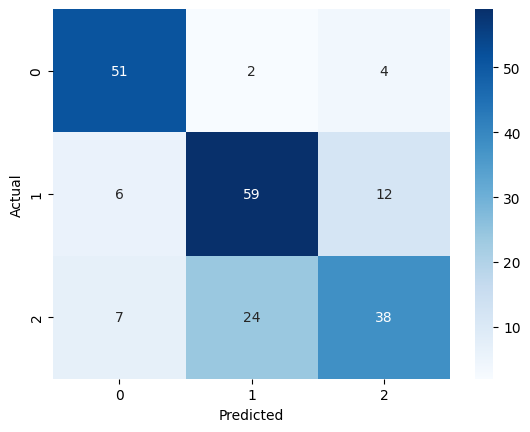

In [32]:
# plot the confusion matrix of  that data to see the mode performace
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show


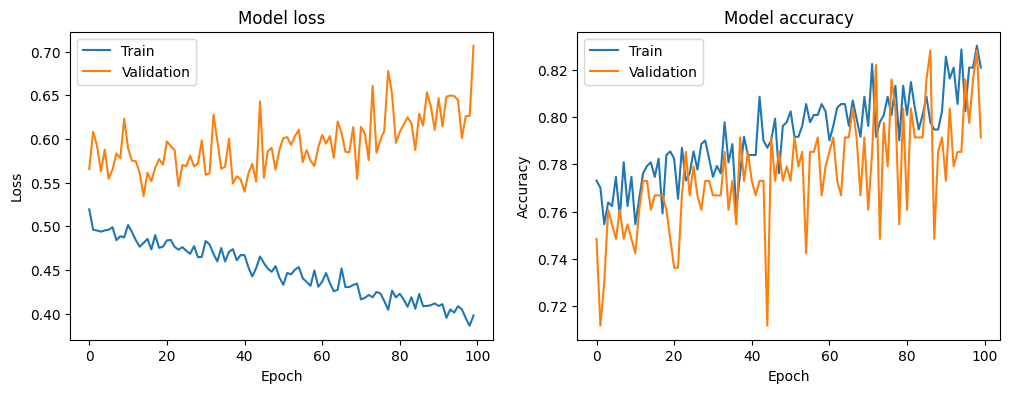

In [33]:
# Summary of the process and results
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [53]:
model2 = Sequential([
          # # Add the first hidden layer
          Dense(128, activation="relu", input_dim=X_train.shape[1],),
          Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
          Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
          Dense(3, activation="softmax")
])



# get the model summary
model2.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               896       
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 3)                 99        
                                                                 
Total params: 11331 (44.26 KB)
Trainable params: 11331 (44.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model with early stopping this time round
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=10,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
  )

Epoch 1/100
65/65 [==============================] - 0s 4ms/step - loss: 0.2217 - accuracy: 0.9074 - val_loss: 0.8057 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 2/100
65/65 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.8981 - val_loss: 0.8066 - val_accuracy: 0.8528 - lr: 1.0000e-04
Epoch 3/100
65/65 [==============================] - 0s 4ms/step - loss: 0.2202 - accuracy: 0.8997 - val_loss: 0.8187 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 4/100
65/65 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.8966 - val_loss: 0.8202 - val_accuracy: 0.8528 - lr: 1.0000e-04
Epoch 5/100
65/65 [==============================] - 0s 4ms/step - loss: 0.2194 - accuracy: 0.8951 - val_loss: 0.8238 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 6/100
65/65 [==============================] - 1s 8ms/step - loss: 0.2189 - accuracy: 0.8981 - val_loss: 0.8209 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 7/100
65/65 [==============================] -

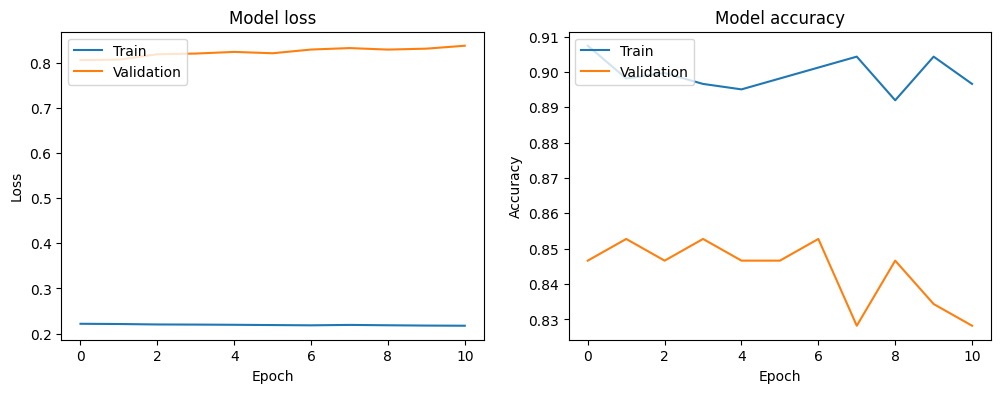

In [55]:
# Summary of the process and results
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()